## U shape PHP dynamics


We solve a set of governing equations: (Zhang et al., 2002)

1. Momentum equation:
 ## $\frac{\mathrm{d}^{2} X_{p}}{\mathrm{d} \tau^{2}}+32 \frac{\mathrm{d} X_{p}}{\mathrm{d} \tau}+\omega_{0}^{2} X_{p}=\wp\left(P_{1}-P_{2}\right)$
 
2. Perfect gas law combined with first law of thermodynamics:

 ## $M_{1}=P_{1}^{1 / \gamma}\left(1+X_{p}\right)$
 
 ## $M_{2}=P_{2}^{1 / \gamma}\left(1-X_{p}\right)$
 
 ## $\theta_{1}=P_{1}^{(\gamma-1) / \gamma}$
 
 ## $\theta_{2}=P_{2}^{(\gamma-1) / \gamma}$

3. The phase change relations between the mass of vapor and the heat transfer from the wall
 ## $\frac{\mathrm{d} M_{1}}{\mathrm{d} \tau}=\left\{\begin{array}{ll}
-H_{\mathrm{c}} X_{p}\left(\theta_{1}-\theta_{\mathrm{c}}\right), & X_{p}>0 \\
-H_{\mathrm{e}}\left(1+X_{p}\right)\left(\theta_{\mathrm{e}}-\theta_{1}\right), & X_{p}<0
\end{array}\right.$
 
 ## $\frac{\mathrm{d} M_{2}}{\mathrm{d} \tau}=\left\{\begin{array}{ll}
H_{\mathrm{e}}\left(1-X_{p}\right)\left(\theta_{\mathrm{e}}-\theta_{2}\right), & X_{p}>0 \\
H_{\mathrm{c}} X_{p}\left(\theta_{2}-\theta_{\mathrm{c}}\right), & X_{p}<0
\end{array}\right.$

 So there are 7 euqations for seven non-dimensional variables: 
 
 $X_p$, the dimensionless position of the left end of the liquid slug.
 
 $M_{1}$, the dimensionless mass of the left vapor plug.
 
 $M_{2}$, the dimensionless mass of the right vapor plug.
 
 $\theta_{1}$, the dimensionless temperature of the left vapor plug.
 
 $\theta_{2}$, the dimensionless temperature of the right vapor plug.
 
 $P_{1}$, the dimensionless static pressure of the left vapor plug.
 
 $P_{2}$, the dimensionless static pressure of the left vapor plug.
 
 
So how to solve them?

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using DifferentialEquations

In [3]:
using DelimitedFiles

In [4]:
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel

include("Postprocessing.jl")
using ..Postprocessing


## Initialization

In [5]:
    ω0 = [sqrt(1.2e004)];
    ℘ = [1.2e005];


    Θ = 0.15;
    θe = 1 + Θ;
    θc = 1 - Θ;
    
    He = 3000.0;
    Hc = 3000.0;


    γ = 1.3;#not 1.4!!!!! maybe 1.33?

In [6]:
    L = 4.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    alpha = pi/2 # inclination angle 

1.5707963267948966

In [7]:
tube = Tube(L,L2D,alpha)

Tube(4.0, 2.0, 1.5707963267948966)

In [8]:
Xe = map(tuple, [0.0; 3.0], [1.0; 4.0])
evap = Evaporator(He,θe,Xe)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)])

In [9]:
Xc = map(tuple, [1.0], [3.0])
cond = Condenser(Hc,θc,Xc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)])

In [10]:
X0 = [(1.5,3.5)]
dXdt0 = [(0.0,0.0)]
liquids=LiquidSlug(γ,ω0,℘,X0,dXdt0)

LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)])

In [11]:
P = [1.0,1.0]

vapors=VaporPlug(γ,P)

VaporPlug(1.3, [1.0, 1.0])

In [12]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors)

PHPSystem(Tube(4.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)]), LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)]), VaporPlug(1.3, [1.0, 1.0]))

## Get numerical solution

In [13]:
Lvaporplug = XptoLvaporplug(X0,L)
M = P.^(1/γ).* Lvaporplug

u=XMtovec(sys0.liquidslug.Xp,sys0.liquidslug.dXdt,M)

6-element Array{Float64,1}:
 1.5
 3.5
 0.0
 0.0
 1.5
 0.5

In [14]:
tstep=1.0e-5

p = sys0
tspan = (0.0, 1.0);
prob = ODEProblem(zhang2002model!, u, tspan, p)
sol = solve(prob, RK4(), adaptive=false, dt=tstep);

In [15]:
result1=soltoResult(sol,sys0);

In [16]:
cd(dirname(pwd()))

cd("data")

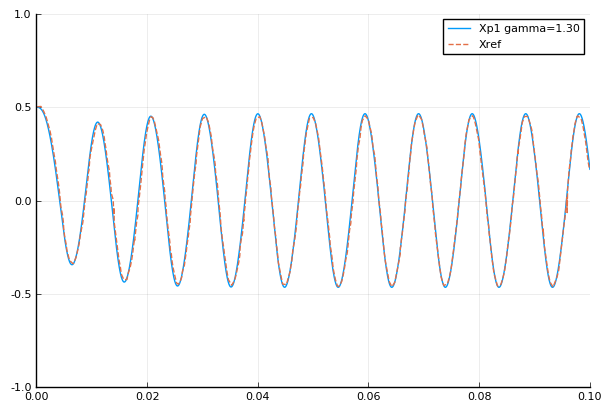

In [25]:
Xprefmatrix = readdlm("Xp.txt",Float64)
plot(result1.t,result1.Xp[1].-1,label="Xp1 gamma=1.30")
plot!(Xprefmatrix[:,1],Xprefmatrix[:,2], line=:dash, label="Xref",xlim=(0.0,0.1),ylim=(-1.0,1.0))
savefig("Xp.pdf")

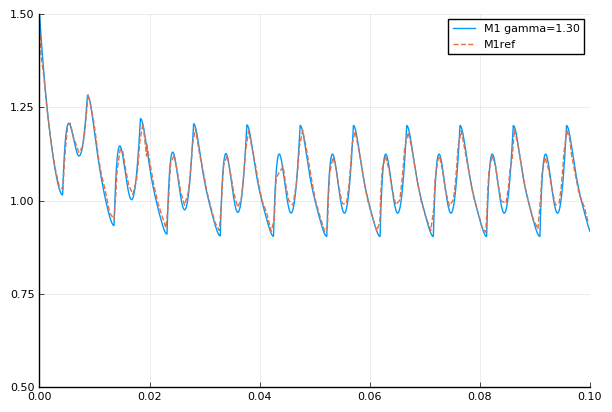

In [27]:
M1refmatrix = readdlm("M1.txt", ',', Float64)
plot(result1.t,result1.M[1],label="M1 gamma=1.30")
plot!(M1refmatrix[:,1],M1refmatrix[:,2], line=:dash, label="M1ref",xlim=(0.0,0.1),ylim=(0.5,1.5))
savefig("M1.pdf")

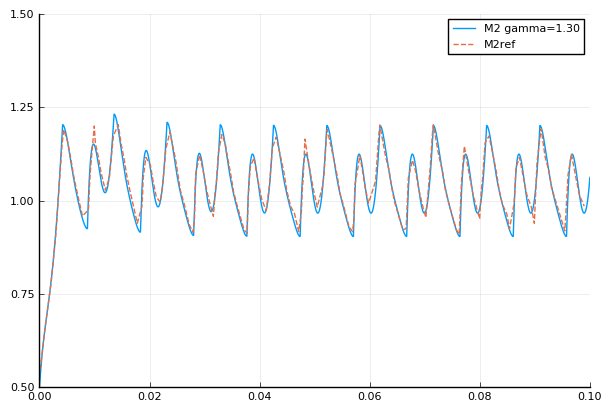

In [28]:
M1refmatrix = readdlm("M2.txt", ',', Float64)
plot(result1.t,result1.M[2],label="M2 gamma=1.30")
plot!(M1refmatrix[:,1],M1refmatrix[:,2], line=:dash, label="M2ref",xlim=(0.0,0.1),ylim=(0.5,1.5))
savefig("M2.pdf")

## Get heat flux from Zhang(2002) model

In [34]:
du=zeros(size(sol.u[1]))
Q1=zeros(length(result1.t));
Q2=zeros(length(result1.t));

In [35]:
for i = 1:length(result1.t)
    Q1[i]=zhang2002model!(du,sol.u[i], p,tspan)[end-1]
    Q2[i]=zhang2002model!(du,sol.u[i], p,tspan)[end]
end

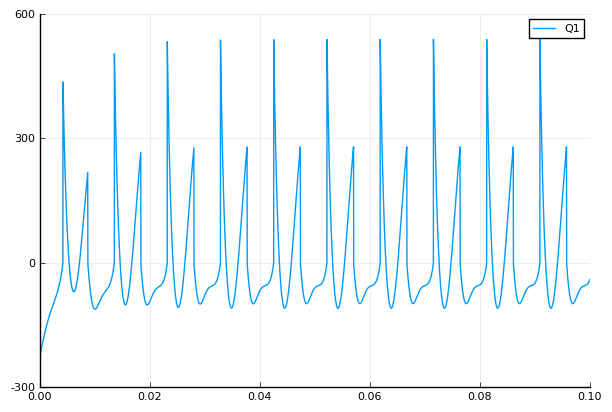

In [40]:
plot(result1.t,Q1,label="Q1",xlim=(0.0,0.1),ylim=(-300,600))
savefig("Heat flux1.pdf")

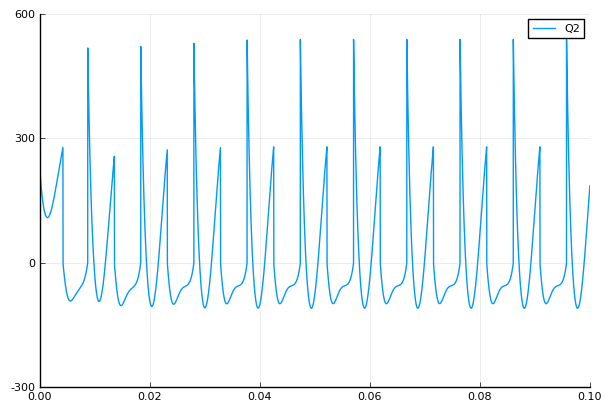

In [41]:
plot(result1.t,Q2,label="Q2",xlim=(0.0,0.1),ylim=(-300,600))
savefig("Heat flux2.pdf")